In [63]:
import numpy as np

In [2]:
import get
import matplotlib.pyplot as plt
import dask
import dask.dataframe as dd
from dask.distributed import Client, progress
from sklearn.preprocessing import MinMaxScaler
client = Client(n_workers=2, threads_per_worker=2, memory_limit='2GB')
client

Client Scheduler: tcp://127.0.0.1:52802 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 4.00 GB


In [3]:
SPY = get.daily('SPY', outputsize = 'full')

In [4]:
SPY = SPY.sort_values('timestamp', ignore_index=True)

In [4]:
SPY

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2000-03-13,136.6875,140.4687,135.6875,138.5937,95.2569,10540500,0.0000,1.0
1,2000-03-14,139.2812,140.0937,136.1562,136.6250,93.9038,8263900,0.0000,1.0
2,2000-03-15,136.8750,140.4375,136.0625,139.8125,96.0946,10300800,0.0000,1.0
3,2000-03-16,141.6250,146.8437,140.8750,146.3437,100.5835,25601400,0.0000,1.0
4,2000-03-17,145.8125,148.0000,145.4375,146.9375,101.2465,10272900,0.3708,1.0
...,...,...,...,...,...,...,...,...,...
5028,2020-03-09,275.3000,284.1900,273.4500,274.2300,274.2300,305980554,0.0000,1.0
5029,2020-03-10,284.6400,288.5200,273.5000,288.4200,288.4200,274894230,0.0000,1.0
5030,2020-03-11,280.7000,281.9400,270.8800,274.3600,274.3600,254604444,0.0000,1.0
5031,2020-03-12,256.0000,266.6600,247.6800,248.1100,248.1100,389612072,0.0000,1.0


In [5]:
SPY = dd.from_pandas(SPY, npartitions = len(SPY.columns))

In [ ]:
%matplotlib qt
plt.figure()
plt.scatter(SPY.timestamp.compute(), SPY.adjusted_close.compute())
#plt.plot(TBBK['volume'])
#plt.plot(SPY["high"])
#plt.plot(SPY["low"])
#plt.plot(SPY["close"])
plt.title('SPY history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
#plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

Computer keeps crashing, but using a little research I found that the first crash is 2008.
Lets look at this a bit closer

In [6]:
type(SPY.timestamp.head()[0])#figure out formatting

str

In [7]:
#thats convenient
SPY = SPY[SPY.timestamp >= '2008-10-01']
SPY =  SPY[SPY.timestamp <= '2008-12-01']

Text(0.5, 0, 'Days')

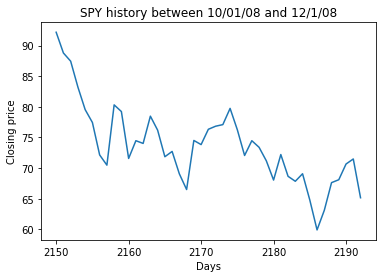

In [9]:
%matplotlib inline
plt.figure()
plt.plot(SPY.adjusted_close.compute())
plt.title('SPY history between 10/01/08 and 12/1/08')
plt.ylabel('Closing price')
plt.xlabel('Days')

That looks pretty clean, and should work pretty well when trained. Time to preprocessing the data

In [31]:
SPY.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'adjusted_close', 'volume',
       'dividend_amount', 'split_coefficient'],
      dtype='object')

In [52]:
#Select the data we wanrt
pre_selected_spy = SPY[['open', 'high','low', 'volume', 'adjusted_close']]
selected_spy = pre_selected_spy.to_dask_array()

In [53]:
sc = MinMaxScaler(feature_range=(0, 1))
scaled_SPY = sc.fit_transform(selected_spy.compute())

In [55]:
scaled_SPY

array([[1.        , 1.        , 1.        , 0.28346138, 1.        ],
       [0.99196384, 0.95585359, 0.92703863, 0.32662242, 0.8950349 ],
       [0.91411351, 0.96535345, 0.89219894, 0.45525668, 0.85349125],
       [0.79608237, 0.74657726, 0.66397374, 0.65316226, 0.7224661 ],
       [0.73505776, 0.73847443, 0.63898006, 0.5593618 , 0.60865322],
       [0.61727775, 0.59457949, 0.56728099, 0.8061303 , 0.54350931],
       [0.60798594, 0.5509919 , 0.40166625, 0.54711398, 0.37930191],
       [0.28402813, 0.36434758, 0.23327443, 1.        , 0.32768059],
       [0.46258162, 0.57138866, 0.39403938, 0.44646615, 0.63249823],
       [0.7345555 , 0.68818106, 0.57485483, 0.56783199, 0.5988203 ],
       [0.55273732, 0.47219894, 0.38803332, 0.48474473, 0.36160326],
       [0.39779006, 0.38753842, 0.30800303, 0.78382239, 0.45132639],
       [0.41536916, 0.49427214, 0.43701086, 0.47501085, 0.43756215],
       [0.49974887, 0.50852193, 0.49859884, 0.26788668, 0.57546787],
       [0.54043194, 0.49566918, 0.

In [66]:
#timestep of 5 days
x_train = list() 
y_train = list()
for i in range(5, scaled_SPY.shape[0]-1):
    x_train.append(scaled_SPY[i-5:i, ])
    y_train.append(scaled_SPY[i+1, 4])
x_t = np.array(x_train)
y_t = np.array(y_train)